# Flash responses

This notebook introduces flash responses and the flash response index (FRI). The FRI measures if a cell depolarizes to bright or to dark increments in a visual input.

##### You can skip the next cells if you are not on google colab but run this locally

**Select GPU runtime**

Only for usage on google colab: to run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [1]:
#@markdown **Check access to GPU**

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch
    try:
      cuda_name = torch.cuda.get_device_name()
      print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
      import warnings
      warnings.warn("You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow).")

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [2]:
if IN_COLAB:
    #@markdown **Install Flyvis**
    %%capture
    !git clone https://github.com/flyvis/flyvis-dev.git
    %cd /content/flyvis-dev
    !pip install -e .

In [3]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['figure.dpi'] = 200

## Flash stimuli

To elicit flash responses, experimenters show a flashing dot to the subject in the center of their field of view. We generate and render these stimuli with the `Flashes` dataset.

In [4]:
# import dataset and visualization helper
from flyvision.animations.hexscatter import HexScatter
from flyvision.datasets.flashes import Flashes

In [5]:
# initialize dataset
dataset = Flashes(
    dynamic_range=[0, 1],  # min and max pixel intensity values, must be in range [0, 1]
    t_stim=1.0,  # duration of flash
    t_pre=1.0,  # duration of period between flashes
    dt=1 / 200,  # temporal resolution of rendered video
    radius=[-1, 6],  # radius of flashing dot. -1 fills entire field of view
    alternations=(0, 1, 0),  # flashing pattern, off - on - off
)

Flashes: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.65it/s]


In [6]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

,baseline,intensity,radius
0,0.5,0,-1
1,0.5,0,6
2,0.5,1,-1
3,0.5,1,6


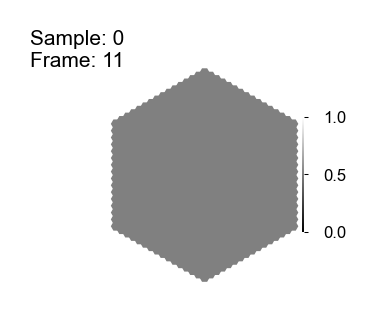

In [7]:
# visualize single sample
animation = HexScatter(
    dataset[3][None, ::50, None], vmin=0, vmax=1
)  # intensity=1, radius=6
animation.animate_in_notebook()

## Network flash response

Now that we have generated the stimulus, we can use it to drive a trained connectome-constrained network.

In [8]:
from flyvision import results_dir
from flyvision.network import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-08-07 12:00:01] [logging_utils.py:8] Loading paper result from stored checkpoint and validation subdir...


In [9]:
# rebuild network from checkpoint
network = network_view.init_network()

[2024-08-07 12:00:10] [network.py:239] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-07 12:00:10] [chkpt_utils.py:68] Recovered network state.


In [10]:
# check out function for running network simulation
help(network.simulate)

Help on method simulate in module flyvision.network:

simulate(movie_input: torch.Tensor, dt: float, initial_state: Optional[flyvision.utils.tensor_utils.AutoDeref] = 'auto', as_states: bool = False) -> Union[torch.Tensor, flyvision.utils.tensor_utils.AutoDeref] method of flyvision.network.Network instance
    Simulate the network activity from movie input.
    
    Args:
        movie_input: tensor requiring shape (batch_size, n_frames, 1, hexals)
        dt: integration time constant. Warns if dt > 1/50.
        initial_state: network activity at the beginning of the simulation.
            Either use fade_in_state or steady_state, to compute the
            initial state from grey input or from ramping up the contrast of
            the first movie frame. Defaults to "auto", which uses the
            steady_state after 1s of grey input.
        as_states: can return the states as AutoDeref dictionary instead of
            a tensor. Defaults to False.
    
    Returns:
        acti

In [11]:
# compute network responses to all flash stimuli
# inputs should be of shape (#samples, #frames, 1, #hexals) so we unsqueeze the 2nd dimension
responses = network.simulate(torch.stack(dataset[:]).unsqueeze(2), dt=dataset.dt)
responses = responses.detach().cpu().numpy()

### FlashResponseView
We've now computed network flash responses for all cells in the network. The `FlashResponseView` class allows us fast and flexible analysis and operations on the stored responses.

In [12]:
from flyvision.analysis.flash_responses import FlashResponseView
from flyvision.utils.nodes_edges_utils import CellTypeArray

# extract cell responses in central column
central_responses = responses[:, :, network.connectome.central_cells_index[:]]
# wrap responses for easy access by cell type
responses_array = CellTypeArray(
    central_responses,
    cell_types=network.connectome.unique_cell_types[:].astype(str),
)

In [13]:
# initialize FlashResponseView
frv = FlashResponseView(
    arg_df=dataset.arg_df, config=dataset.config, responses=responses_array
)

### Response traces

We can plot single-cell response traces with `FlashResponseView.plot_traces()`. Here, we plot responses of L1 cells to flashes with radius 6.

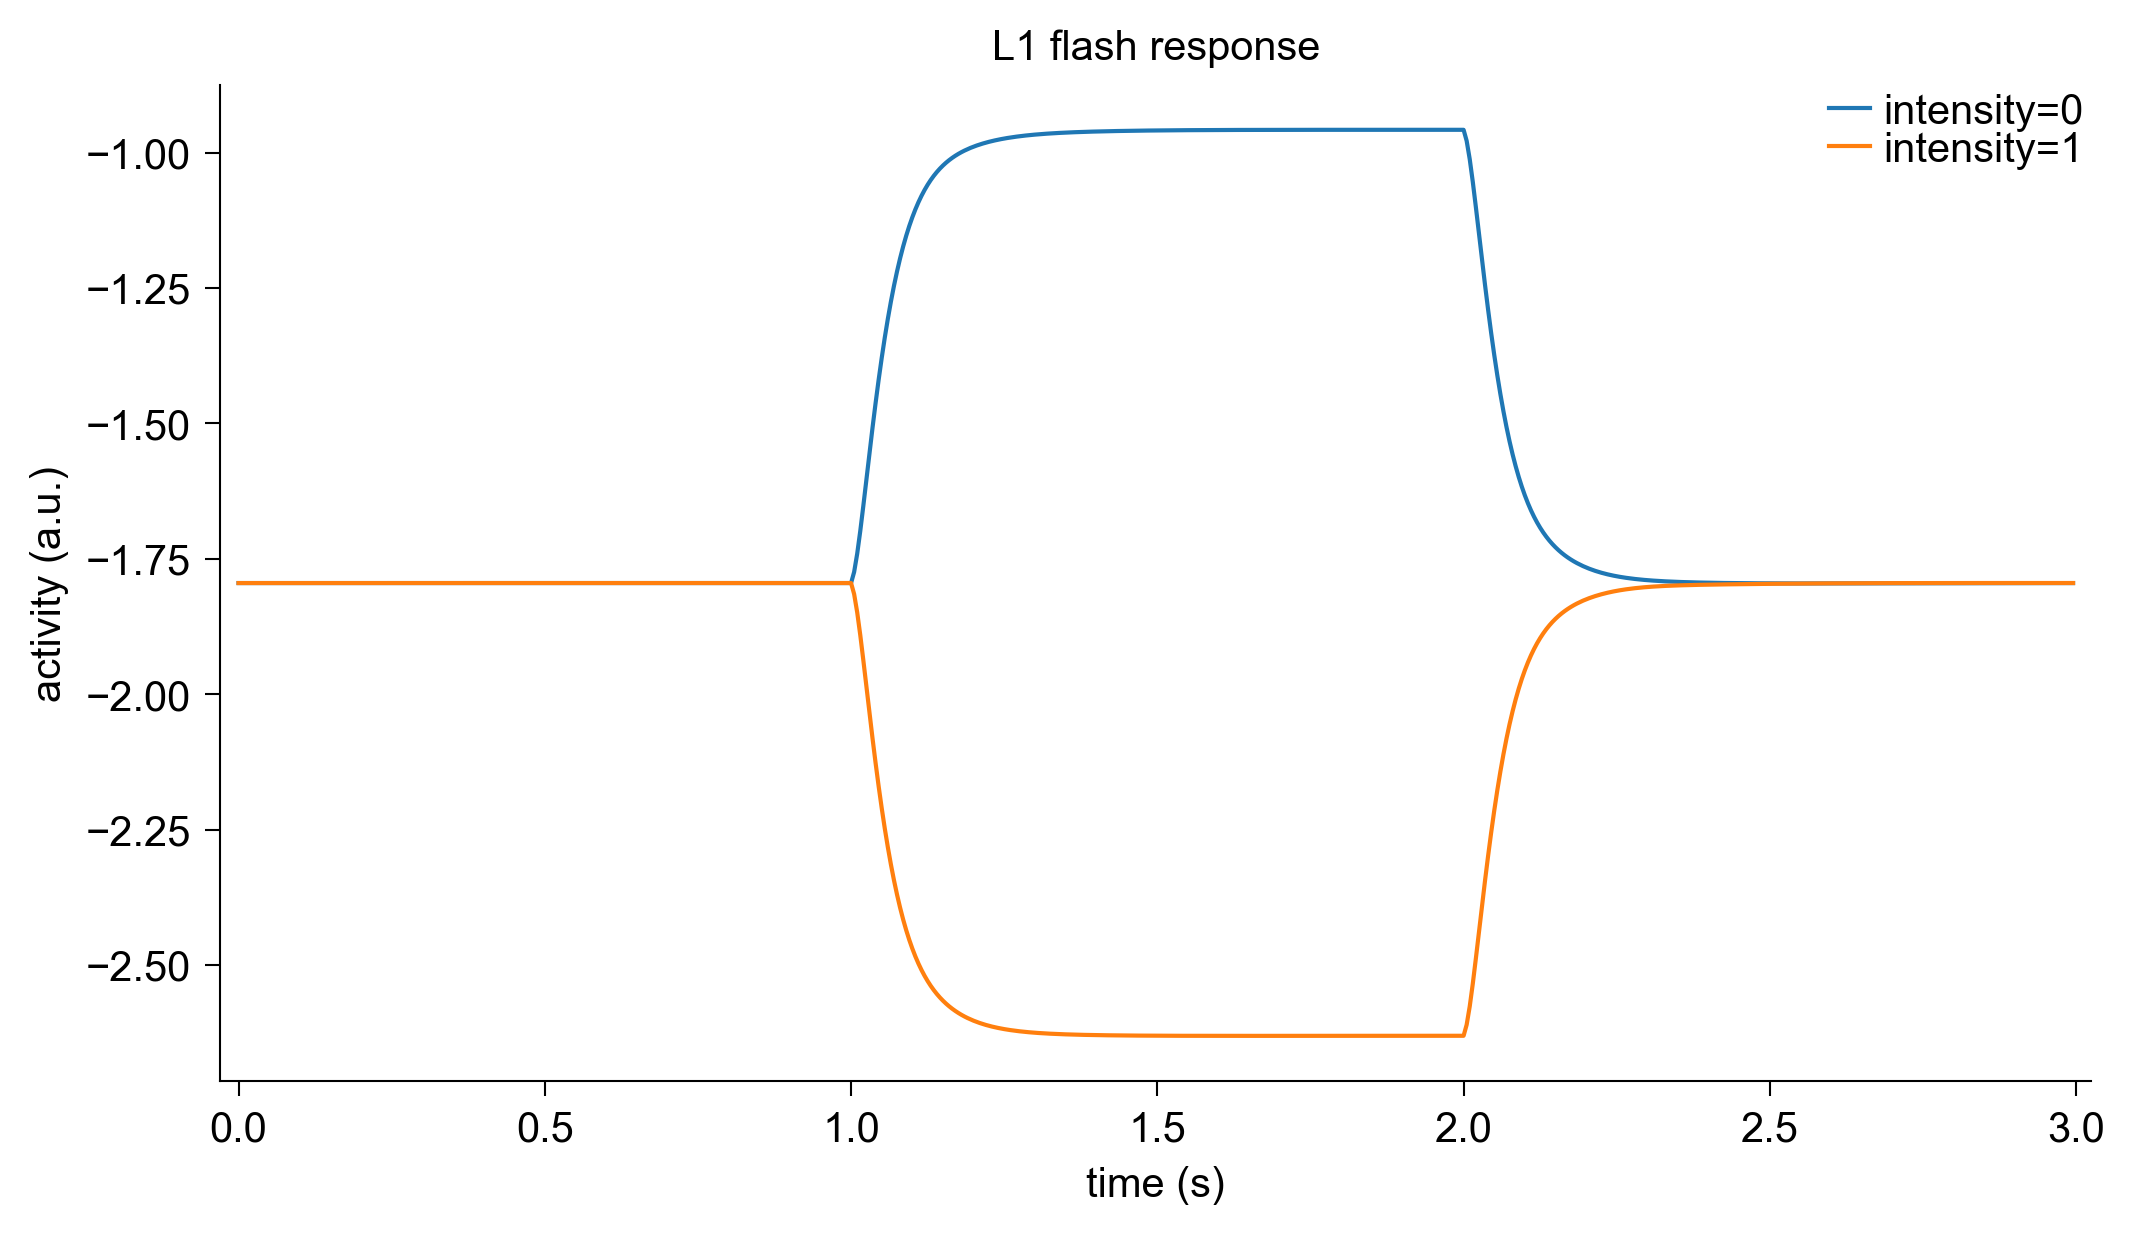

In [14]:
# %#matplotlib inline
fig, *_ = frv.plot_traces("L1", radius=6)
fig.show()

### Flash response index (FRI)

The flash response index (FRI) is a measure of the strength of contrast tuning of a particular cell. It is computed as the difference between the cell's peak voltage in response to on-flashes (intensity = 1) and off-flashes (intensity = 0), divided by the sum of those peak values.

That is, given a single neuron's response to on-flashes `r_on` and off-flashes `r_off` (both of `shape=(T,)`), we can compute the flash response index with

```
r_on_max = max(r_on)
r_off_max = max(r_off)
fri = (r_on_max - r_off_max) / (r_on_max + r_off_max + 1e-16)
```

with the additional `1e-16` simply for numerical stability. Before this calculation, the response traces are shifted to be non-negative.

The flash response index can take on values between $-1$, when the off response is much stronger (or more positive) than the on response, to $1$, when the on response is much stronger (or more positive) than the off response.

For the L1 cell plotted before, we can see that it displays a positive response to off flashes and a negative response to on flashes, so we expect a negative flash response index.

In [15]:
# get FRI for L1 cell
fri_l1 = frv.cell_type("L1").fri(radius=6).responses.array.item()
print(fri_l1)

-0.3335401030066458


### FRI correlation

With the `fri()` function we can also compute FRIs for every cell type at once. Since the tuning of some cell types have been determined experimentally, we can then compare our model to experimental findings by computing the correlation between the model FRIs for known cell types with their expected tuning.

In [16]:
from flyvision.analysis.flash_responses import fri_correlation_to_known
from flyvision.utils.groundtruth_utils import polarity

# compute FRis for all cell types
fri_all = frv.fri(radius=6)
# get FRi values and corresponding cell types
fris = fri_all.responses.array[0]
cell_types = fri_all.responses.cell_types
# compute correlation
fri_corr = fri_correlation_to_known(fris, cell_types)
print(fri_corr[0])

0.8056431614607255


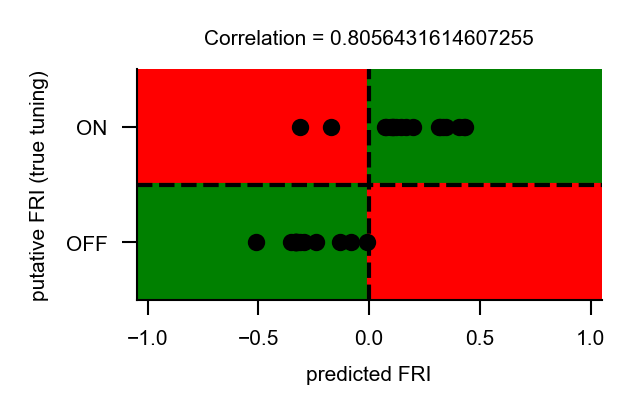

In [17]:
# manually extract model and true FRIs for plotting
known_cell_types = [k for k, v in polarity.items() if v != 0]
model_fris = [fri_all.responses[k].item() for k in known_cell_types]
true_fris = [polarity[k] for k in known_cell_types]
# plot
plt.figure(figsize=[2, 1])
plt.scatter(model_fris, true_fris, color="k", s=10)
plt.xlabel("predicted FRI")
plt.ylabel("putative FRI (true tuning)")
plt.axvline(0, linestyle="--", color="black")
plt.axhline(0, linestyle="--", color="black")

plt.axhspan(0, 2, 0, 0.5, color="red", zorder=-10)
plt.axhspan(0, 2, 0.5, 1.0, color="green", zorder=-10)
plt.axhspan(-2, 0, 0, 0.5, color="green", zorder=-10)
plt.axhspan(-2, 0, 0.5, 1.0, color="red", zorder=-10)

plt.xlim(-1.05, 1.05)
plt.ylim(-2, 2)
plt.title(f"Correlation = {fri_corr[0]}")
plt.yticks([-1, 1], ["OFF", "ON"])
plt.show()

As we can see, for all except two cell types, the model correctly predicts the cell's tuning (positive or negative).

## Ensemble responses

Now we can compare tuning properties across an ensemble of trained models. First we need to again simulate the network responses.

In [18]:
from flyvision.ensemble import EnsembleView

ensemble = EnsembleView(results_dir / "flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
central_cells_index = ensemble[ensemble.names[0]].connectome.central_cells_index[:]
with ensemble.ratio(
    best=0.20
):  # take only top 20% (10 in this case) of models, for speed
    responses = np.stack(
        [
            resp[:, :, central_cells_index].copy()
            for resp in ensemble.simulate(
                torch.stack(dataset[:]).unsqueeze(2).to("cuda"), dt=dataset.dt
            )
        ],
        axis=0,
    )

Simulating network:   0%|          | 0/10 [00:00<?, ?it/s]

[2024-08-07 12:00:33] [network.py:239] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-08-07 12:00:33] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:34] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:35] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:36] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:37] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:39] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:40] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:41] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:42] [chkpt_utils.py:68] Recovered network state.
[2024-08-07 12:00:43] [chkpt_utils.py:68] Recovered network state.


We again use `FlashResponseView` to wrap around the network flash responses.

In [20]:
responses_array = CellTypeArray(
    responses,
    cell_types=network.connectome.unique_cell_types[:].astype(str),
)

In [21]:
frv = FlashResponseView(
    arg_df=dataset.arg_df,
    config=dataset.config,
    responses=responses_array,
    stim_sample_dim=1,
    temporal_dim=2,
)

### Response traces

We can once again plot response traces for a single cell type. We subtract the initial value of each trace to center the data before plotting, as the network neuron activities are in arbitrary units.

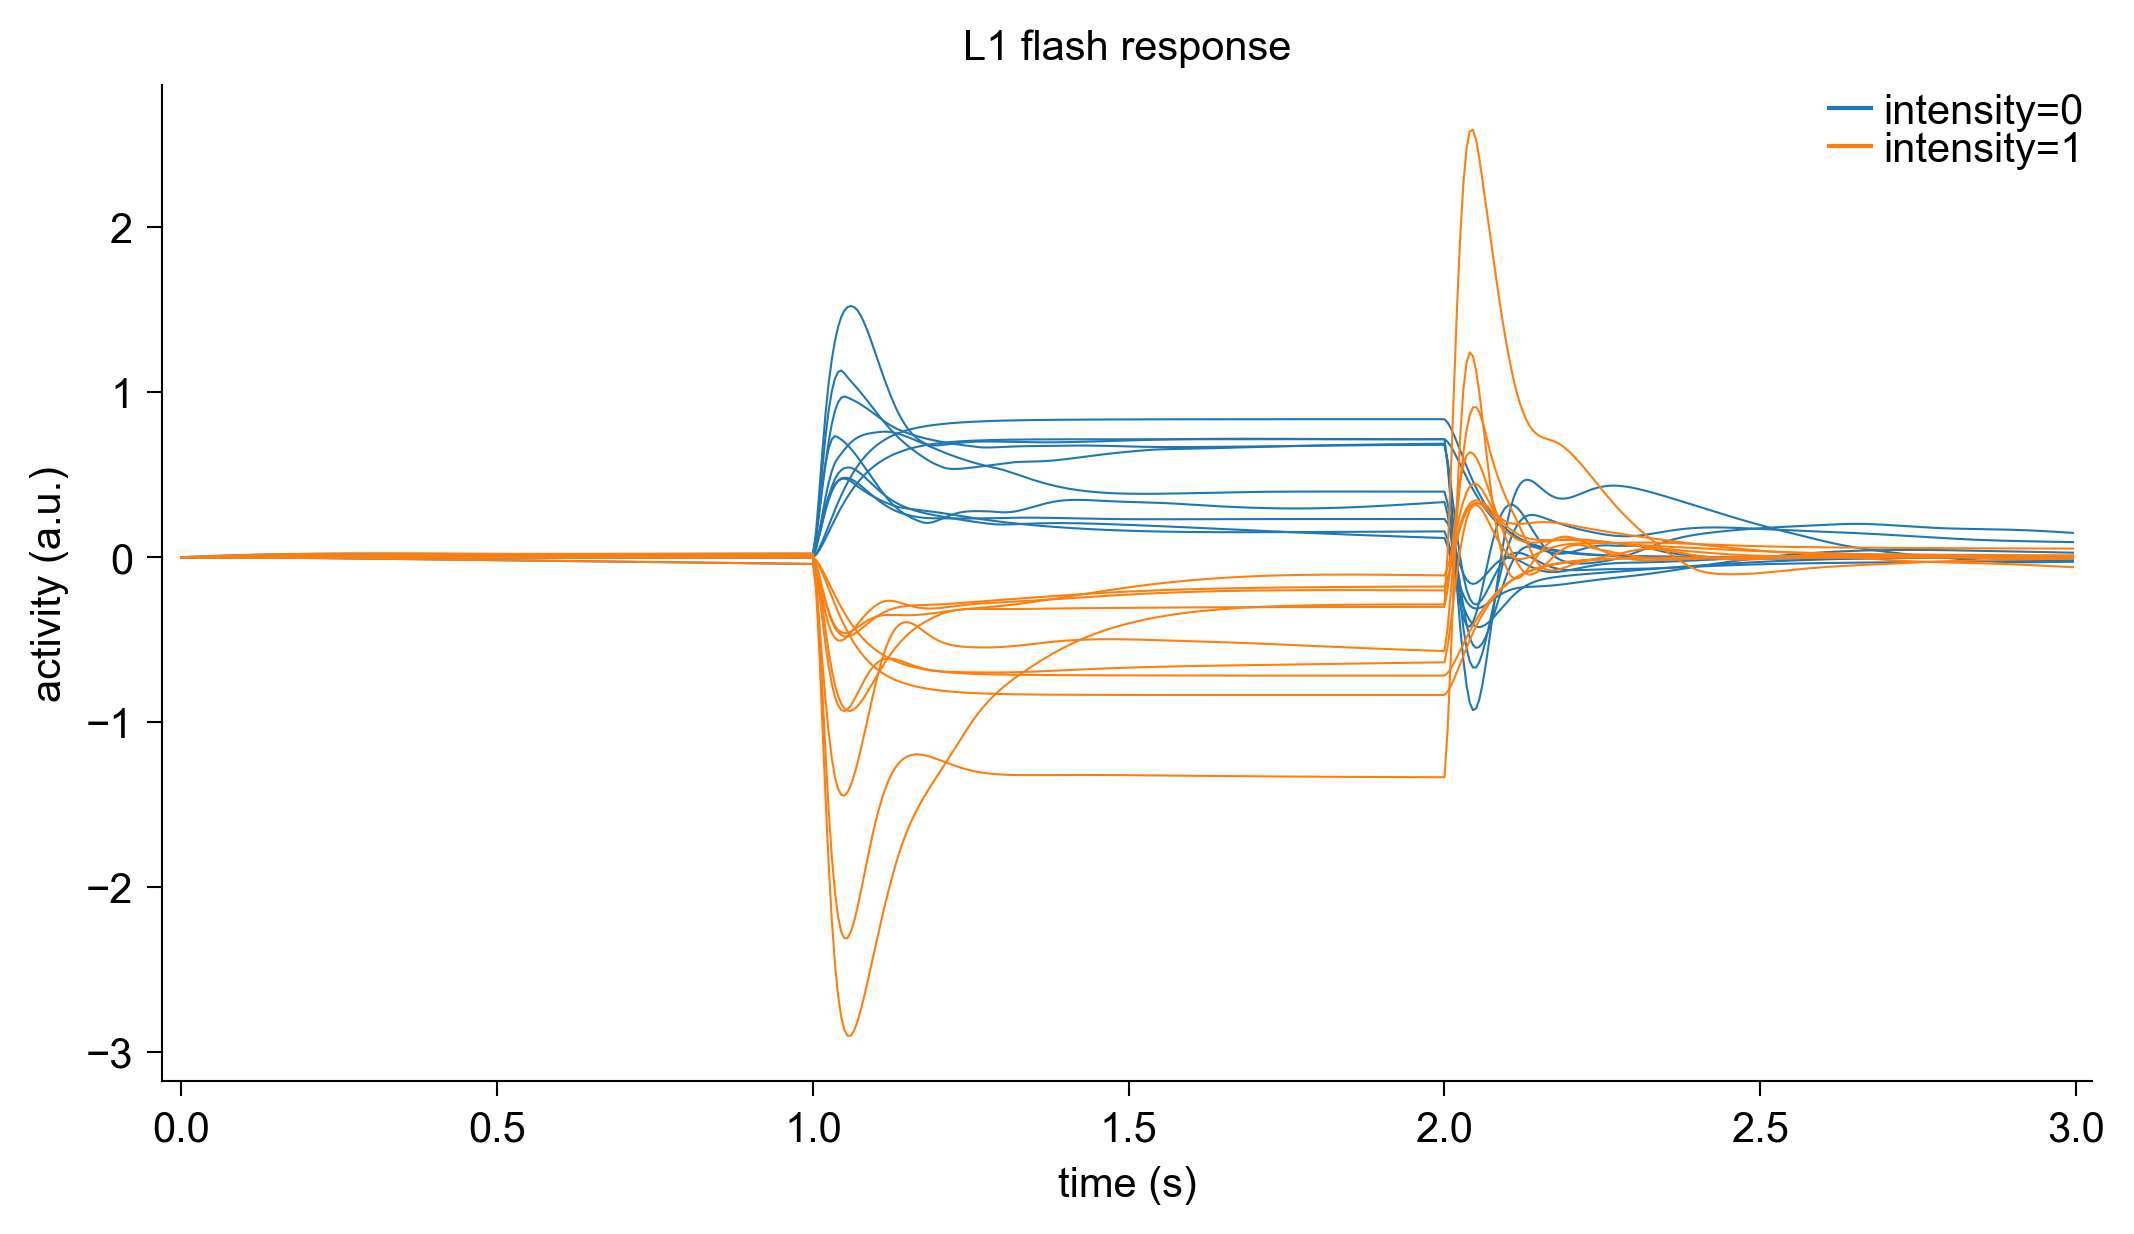

In [22]:
centered = frv - frv.responses.array[:, :, [0]]
fig, ax = centered.plot_traces("L1", radius=6)
fig.show()

Though the scaling varies, all networks recover the same tuning for L1.

### Flash response index (FRI)

We can also compute flash response indices for each network in the ensemble.

In [23]:
# get FRI for L1 cell
fri_l1 = frv.cell_type("L1").fri(radius=6).responses.array.squeeze().tolist()
print(fri_l1)

[-0.3335401030066458, -0.28763249615563174, -0.32586821162221963, -0.20794408117929758, -0.33343361357485574, -0.32148297460680125, -0.13273868569973984, -0.35656808288583103, -0.29450417591578715, -0.3328605236507244]


All models recover similar flash response indices for this cell type. We can also plot the distribution of FRIs per cell type across the ensemble.

In [24]:
# compute FRIs for all cell types
fri_all = frv.fri(radius=6)
# get FRI values and corresponding cell types
fris = fri_all.responses.array.squeeze()
cell_types = fri_all.responses.cell_types

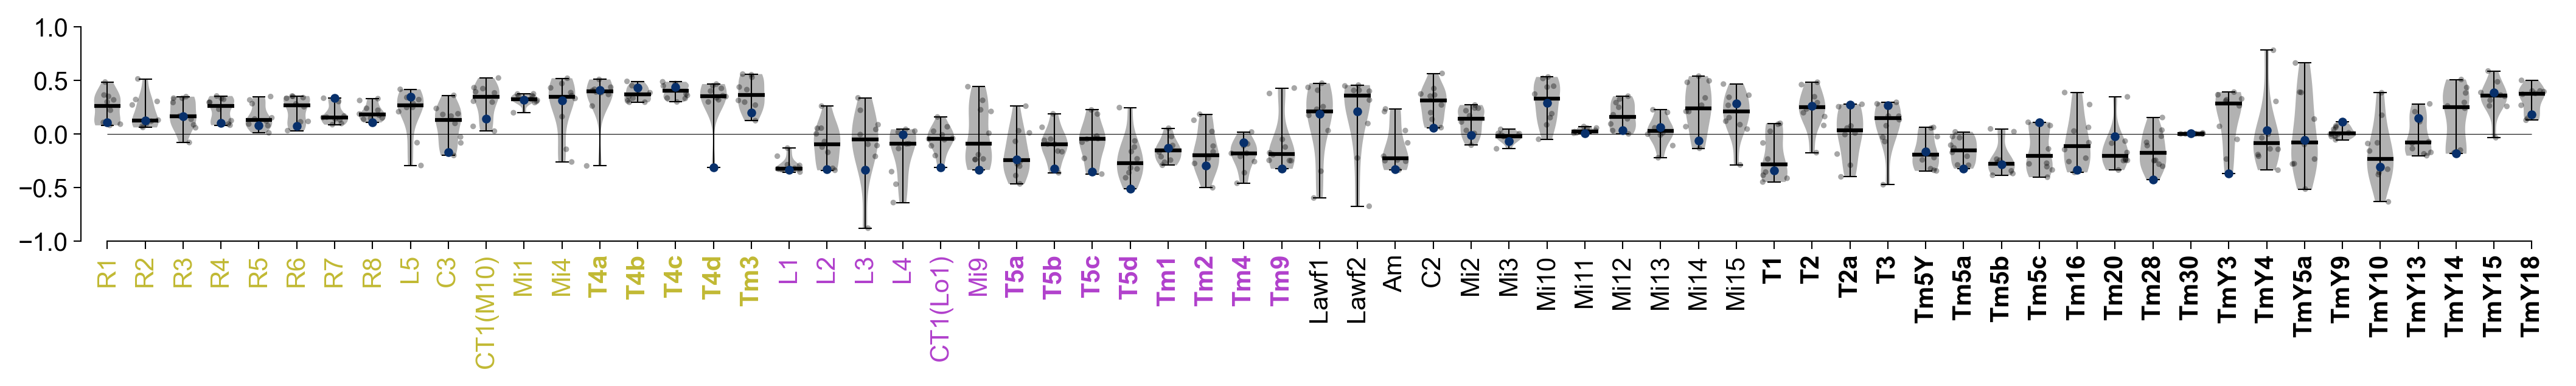

In [25]:
from flyvision.analysis.flash_responses import plot_fris

fig, ax = plot_fris(
    fris,
    cell_types,
    scatter_best=True,
    scatter_all=True,
    bold_output_type_labels=True,
    output_cell_types=ensemble[ensemble.names[0]]
    .connectome.output_cell_types[:]
    .astype(str),
    known_first=True,
    figsize=[14, 2],
    cmap=plt.cm.Greys_r,
    ylim=(-1, 1),
    color_known_types=True,
    fontsize=10,
    scatter_best_index=0,
    scatter_best_color=plt.get_cmap("Blues")(1.0),
)
fig.show()

### FRI correlation

Lastly, we look at the correlations to ground-truth tuning across the ensemble.

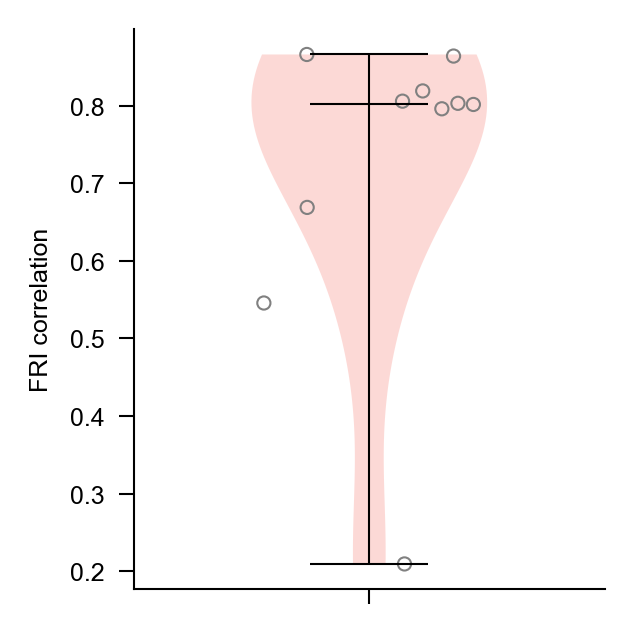

In [26]:
from flyvision.plots.plots import violin_groups

# compute correlation
fri_corr = fri_correlation_to_known(fris, cell_types)

fig, ax, *_ = violin_groups(
    np.array(fri_corr)[None, None, :],
    ylabel="FRI correlation",
    figsize=(2, 2),
    xlim=(0, 1),
    xticklabels=[],
    colors=[plt.get_cmap("Pastel1")(0.0)],
    scatter_edge_color="gray",
    scatter_radius=10,
)

Models in general have very good match to known single-neuron tuning properties, with median correlation around 0.8.